In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import seaborn as sns
import tangram as tg
import geopandas as gpd
from shapely.geometry import Polygon
import muon as mu
import anndata as ad

%load_ext autoreload
%autoreload 2
%matplotlib inline

/nfs/home/students/l.reich/mamba/envs/neu/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/nfs/home/students/l.reich/mamba/envs/neu/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/nfs/home/students/l.reich/mamba/envs/neu/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/nfs/home/students/l.reich/mamba/envs/neu/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/nfs/home/students/l.reich/mamba/envs/neu/lib/python3.10/site-packages/anndata

In [2]:
import os
import sys
from pathlib import Path

# Add the src directory to the path if it's not already there
notebook_dir = Path(os.getcwd())
if notebook_dir.name == 'src':
    sys.path.append(".")  # Add current directory
else:
    sys.path.append(str(notebook_dir / "src"))  # Add src directory

from config import H5AD_DIR, get_h5ad_path

In [3]:
sc.read_h5ad(get_h5ad_path("spatial_filtered.h5ad"))

AnnData object with n_obs × n_vars = 5519 × 254
    obs: 'sample_id', 'slice_id', 'class_label', 'subclass', 'label', 'cell_id', 'centroid_x', 'centroid_y'
    uns: 'subclass_colors'
    obsm: 'spatial'

In [4]:
# read ad objects

ad_sp = sc.read_h5ad(get_h5ad_path("spatial_filtered.h5ad"))

ad_sc = sc.read_h5ad(get_h5ad_path("subsetted_sc.h5ad"))

#ad_atac = sc.read_h5ad("atac.h5ad")
ad_atac = sc.read_h5ad(get_h5ad_path("atac_with_correct_barcodes.h5ad"))

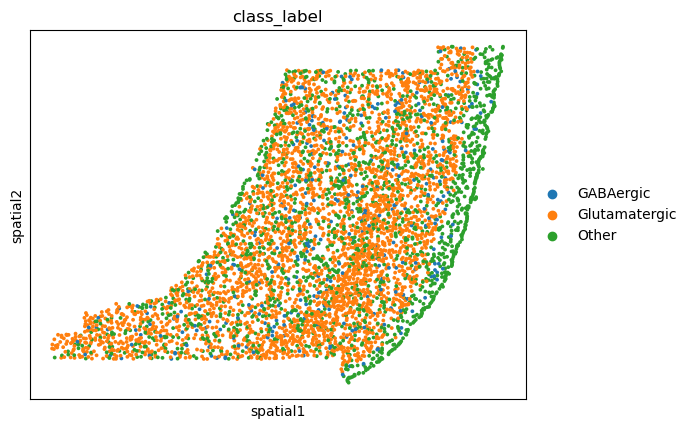

In [5]:
sc.pl.embedding(ad_sp, basis="spatial", color="class_label", cmap="inferno", size=30)

In [6]:
def add_cell_categories(adata):
    # Define the category mappings
    glutamatergic = ['EN01', 'EN02', 'EN03', 'EN04', 'EN05', 'EN06', 'EN07', 'EN08', 'EN09']
    gabaergic = ['IN01', 'IN02', 'IN03', 'IN04', 'IN05']
    non_neuronal = ['A1.E1', 'MX', 'NSC', 'OG1', 'P1']
    
    # Create a new column for the broader category
    category_map = {}
    for cell_type in glutamatergic:
        category_map[cell_type] = 'Glutamatergic'
    for cell_type in gabaergic:
        category_map[cell_type] = 'GABAergic'
    for cell_type in non_neuronal:
        category_map[cell_type] = 'Non-neuronal'
    
    # Add the new category column to the AnnData object
    adata.obs['class_label'] = adata.obs['celltype'].map(category_map)
    
    # Check if any cell types were not mapped
    unmapped = adata.obs.loc[adata.obs['class_label'].isna(), 'celltype'].unique()
    if len(unmapped) > 0:
        print(f"Warning: The following cell types were not mapped to a category: {list(unmapped)}")
    
    return adata

In [7]:
# Use the function
ad_sc = add_cell_categories(ad_sc)

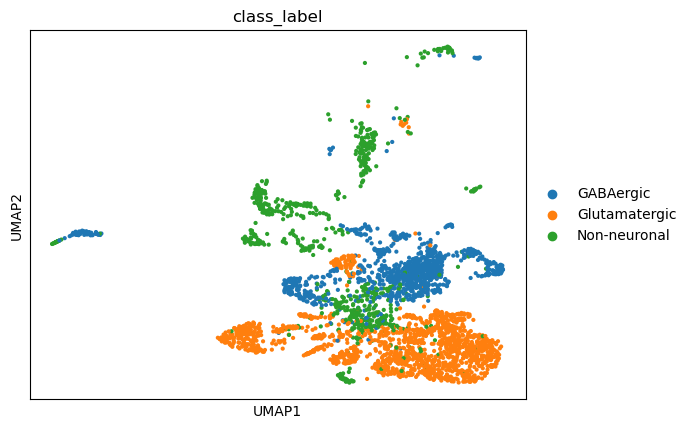

In [8]:
sc.pl.umap(ad_sc, color=["class_label"])

In [9]:
ad_map = sc.read_h5ad(get_h5ad_path("newest_ad_map.h5ad"))

In [10]:
# Force the indices to be the same (assuming the cells are in the same order)
ad_atac_copy = ad_atac.copy()
ad_atac_copy.obs_names = ad_map.obs_names

In [11]:
ad_atac_spatial = tg.project_genes(ad_map, ad_atac_copy)

In [12]:
ad_atac_spatial.obsm["spatial"] = np.array(ad_atac_spatial.obs[["centroid_x", "centroid_y"]])

In [13]:
fragments_file = 'data/mouse_brain_data/sorted.bed.gz'

In [14]:
mu.atac.tl.locate_fragments(ad_atac, fragments='/nfs/home/students/l.reich/tangram/data/mouse_brain_data/sorted.bed.gz')

Für count_fragments_features brauche ich die Koordinaten der Gene von scRNA

In [15]:
import requests
import io

# Download gene coordinates from UCSC (mouse mm10)
try:
    url = "http://hgdownload.soe.ucsc.edu/goldenPath/mm10/database/refGene.txt.gz"
    response = requests.get(url)
    genes_table = pd.read_csv(io.BytesIO(response.content), compression='gzip', 
                             sep='\t', header=None)
    
    # Process the UCSC refGene format
    gene_coords = pd.DataFrame({
        'gene_name': genes_table[12],               # name2 (gene symbol)
        'chrom': genes_table[2],                    # chromosome
        'start': genes_table[4],                    # txStart
        'end': genes_table[5],                      # txEnd
        'strand': genes_table[3]                    # strand
    })
    
    # Create interval string (useful for some tools)
    gene_coords['interval'] = gene_coords['chrom'] + ':' + gene_coords['start'].astype(str) + '-' + gene_coords['end'].astype(str)
    
    # Set gene_name as index for easier merging
    gene_coords = gene_coords.set_index('gene_name')
    
    print(f"Downloaded coordinates for {len(gene_coords)} genes")
except Exception as e:
    print(f"Could not download gene annotations: {e}")

Downloaded coordinates for 47382 genes


In [16]:
gene_coords = gene_coords[~gene_coords["chrom"].str.contains("chrY")]

In [17]:
common_genes = ad_sc.var_names.intersection(gene_coords.index)

In [18]:
ad_sc_with_coords = ad_sc[:, list(common_genes)].copy()

In [19]:
# Create a MuData object with RNA and ATAC
mdata = mu.MuData({'atac': ad_atac, 'rna': ad_sc_with_coords})

In [28]:
ad_atac

AnnData object with n_obs × n_vars = 3293 × 428041
    obs: 'barcode', 'atac_barcode', 'formatted_barcode', 'celltype'
    var: 'chrom', 'start', 'end'
    uns: 'files'

In [20]:
mu.atac.tl.initialise_default_files(mdata, path="data/mouse_brain_data/")

In [21]:
# Group by gene_name and take the lowest start position
gene_coords_filtered = gene_coords.loc[common_genes].groupby(level=0).agg({
    'chrom': 'first',  # Keep the chromosome
    'start': 'min',  # Use the smallest start site (most upstream TSS)
    'end': 'max',  # Use the largest end site (covers all isoforms)
    'strand': 'first'  # Keep strand information
})

In [22]:
features = gene_coords_filtered.rename(columns={'chrom': 'chromosome'})[['chromosome', 'start', 'end', 'strand']]
features = features.rename(columns={'chromosome': 'chrom'})
features = features.rename(columns={'strand': 'Strand'})

In [23]:
broad_features = features.copy()
broad_features['start'] = broad_features['start'].astype(int)
broad_features['end'] = broad_features['end'].astype(int)

# 4. Try gene activity with broader regions
gene_activity = mu.atac.tl.count_fragments_features(
    mdata,
    features=features,
    stranded=True,
    #stranded=False,
    #extend_upstream=0,  # No need for extension since regions are already broad
    #extend_downstream=0,
    count_reads=False
)

print("Gene activity sum with broad regions:", gene_activity.X.sum())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17539/17539 [01:12<00:00, 240.44it/s]


Gene activity sum with broad regions: 12582990


In [24]:
gene_activity.obs_names = ad_map.obs_names

In [25]:
gene_activity_spatial = tg.project_genes(ad_map, gene_activity)

In [31]:
gene_activity_spatial

AnnData object with n_obs × n_vars = 5519 × 17517
    obs: 'sample_id', 'slice_id', 'class_label', 'subclass', 'label', 'cell_id', 'centroid_x', 'centroid_y', 'uniform_density', 'rna_count_based_density'
    var: 'chrom', 'start', 'end', 'Strand', 'n_cells', 'is_training'
    obsm: 'spatial'

In [26]:
gene_activity_spatial.obsm["spatial"] = np.array(gene_activity_spatial.obs[["centroid_x", "centroid_y"]])

In [34]:
valid_coords = ~np.isnan(gene_activity_spatial.obsm['spatial']).any(axis=1)

In [35]:
gene_activity_spatial_wo_nan = gene_activity_spatial[valid_coords].copy()

In [37]:
gene_activity_spatial_wo_nan.write(get_h5ad_path("atac_spatial.h5ad"))

In [43]:
genes_of_interest = ['c1ql3', 'il1rapl2', 'kcng1', 'scgn', 'il4ra', 'mrgprx2', 'dnase1l3', 'egfr', 'elfn1']

In [44]:
spatially_variable_genes = [
    "gfap",
    "igf2",
    "rorb",
    "rspo1",
    "cux2",
    "lamp5",
    "unc5d",
    "calb1",
    "fam19a2",
    "slc17a6"
]

In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt
import os
import numpy as np
import scipy.sparse

# List of spatially variable genes
spatially_variable_genes = [
    "gfap",
    "igf2",
    "rorb",
    "rspo1",
    "cux2",
    "lamp5",
    "unc5d",
    "calb1",
    "fam19a2",
    "slc17a6"
]

# Define the two classes
classes = ['Glutamatergic', 'Other']

# Create output directory for plots if it doesn't exist
output_dir = "spatial_plots_by_class"
os.makedirs(output_dir, exist_ok=True)

# Loop through each gene
for gene in genes_of_interest:
    # Check if gene exists in dataset
    if gene not in gene_activity_spatial.var_names:
        print(f"Warning: Gene {gene} not found in dataset. Skipping.")
        continue
    
    # Determine global min and max values for the gene across all cells
    if scipy.sparse.issparse(gene_activity_spatial.X):
        gene_idx = np.where(gene_activity_spatial.var_names == gene)[0][0]
        all_values = gene_activity_spatial.X[:, gene_idx].toarray().flatten()
    else:
        all_values = gene_activity_spatial[:, gene].X.flatten()
    
    vmin = np.min(all_values)
    vmax = np.max(all_values)
    
    # Create a figure with subplots for each class
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot each class separately
    for i, class_name in enumerate(classes):
        # Subset the data for this class
        subset = gene_activity_spatial[gene_activity_spatial.obs['class_label'] == class_name].copy()
        
        # Skip if no cells of this class
        if subset.shape[0] == 0:
            axes[i].text(0.5, 0.5, f"No {class_name} cells", 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'{gene} in {class_name} cells')
            axes[i].axis('off')
            continue
        
        # Use sc.pl.spatial to plot the gene activity with consistent color scale
        sc.pl.spatial(subset, 
                     img_key=None,
                     color=gene,
                     size=20,
                     ax=axes[i],
                     show=False,
                     title=f'{gene} in {class_name} cells',
                     colorbar_loc='right',
                     spot_size=5,
                     vmin=vmin,
                     vmax=vmax)  # Set the same color scale max for all plots
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{gene}_spatial_by_class.png", dpi=300, bbox_inches='tight')
    plt.close(fig)  # Close the figure to free memory
    
    print(f"Created plot for {gene}")

print(f"All plots saved to {output_dir}/")

Created plot for c1ql3
Created plot for il1rapl2
Created plot for kcng1


In [ ]:
overlapping_genes = set(ad_sc.var_names.str.lower()) & set(ad_sp.var_names.str.lower())

In [ ]:
tg.pp_adatas(ad_sc, ad_sp, genes=overlapping_genes)

In [ ]:
gene_ad = tg.project_genes(ad_map, ad_sc)

In [ ]:
df_gene_score = tg.utils.compare_spatial_geneexp(adata_ge=gene_ad, adata_sc=ad_sc, adata_sp=ad_sp)

In [ ]:
tg.plot_utils.plot_training_scores(ad_map)

In [ ]:
classes = ['Glutamatergic', 'GABAergic', 'Other']
gene = "gfap"
# Plot each class separately
for i, class_name in enumerate(classes):
    # Subset the data for this class
    subset = gene_activity_spatial[gene_activity_spatial.obs['class_label'] == class_name].copy()
    
    # Use sc.pl.spatial to plot the gene activity
    sc.pl.spatial(subset, 
                 img_key=None,  # Set to None if you don't have an image
                 color=gene,
                 size=20,
                 title=f'{gene} in {class_name} cells',
                 colorbar_loc='right',
                 spot_size=5)

In [ ]:
# For gene activity scores - each plot normalized to its own range
for gene in genes_of_interest:
    if gene in gene_activity_spatial.var_names:
        # Get values for this gene
        values = gene_activity_spatial[:, gene].X
        if hasattr(values, 'toarray'):
            values = values.toarray().flatten()
        
        # Set range to min and max of this gene
        vmin = np.min(values)
        vmax = np.max(values)
        
        # Plot with range normalized to this specific gene
        sc.pl.spatial(gene_activity_spatial, color=gene, 
                     size=10, spot_size=7, 
                     vmin=vmin, vmax=vmax,
                     cmap="inferno",

                     title=f"{gene} - Chromatin Accessibility")


## TODO
how to link atac peaks to genes

## spatially variable

In [ ]:
# Identify cells with non-NaN coordinates
valid_cells = ~np.isnan(ad_sp.obsm['spatial']).any(axis=1)

In [ ]:
# Subset the AnnData object
ad_sp_clean = ad_sp[valid_cells].copy()

sq.gr.spatial_neighbors(ad_sp_clean)

In [ ]:
sq.gr.spatial_autocorr(ad_sp_clean, mode="moran")

In [ ]:
sp_variable_df = ad_sp_clean.uns["moranI"]

In [ ]:
sp_variable_df.head(n=10)

In [ ]:
sq.pl.spatial_scatter(
    ad_sp_clean, shape=None, color=["gfap", "igf2", "rorb", "slc17a6"], size=30, alpha=1,
)

In [ ]:
sq.pl.spatial_scatter(
    ad_sp_clean, shape=None, color=["rorb"], size=50, alpha=1,
)

In [ ]:
sq.pl.spatial_scatter(
    ad_sp_clean, shape=None, color=["rspo1"], size=10, alpha=1,
)

In [ ]:
gene_ad_filtered= tg.project_genes(ad_map, ad_sc)

In [ ]:
gene_activity_spatial_clean = gene_activity_spatial[~np.isnan(gene_activity_spatial.obsm['spatial']).any(axis=1)].copy()

In [ ]:
sq.gr.spatial_neighbors(gene_activity_spatial_clean)

In [ ]:
sq.gr.spatial_autocorr(gene_activity_spatial_clean, mode="geary")

In [ ]:
gene_activity_spatial_clean.uns["gearyC"]

In [ ]:
atac_variable_df = gene_activity_spatial_clean.uns["moranI"]

In [ ]:
sq.pl.spatial_scatter(
    gene_activity_spatial_clean, shape=None, color=["kcnma1", "zfpm2", "gm6367", "slc17a6"], size=30, alpha=1,
)